#一个神经网络的典型训练过程如下：

1. 定义包含一些可学习参数(或者叫权重）的神经网络

2. 在输入数据集上迭代

3. 通过网络处理输入

4. 计算 loss (输出和正确答案的距离）

5. 将梯度反向传播给网络的参数

6. 更新网络的权重，一般使用一个简单的规则：$weight = weight - learning\_rate * gradient$

In [ ]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES']='0'
batch_size=256
num_workers=4
lr=1e-4
epochs=20

## 数据读入
PyTorch数据读入是通过Dataset+DataLoader的方式完成的，Dataset定义好数据的格式和数据变换形式，DataLoader用iterative的方式不断读入批次数据。

In [ ]:
#首先设置数据变换
from torchvision import transforms
image_size=28
data_transform=transforms.Compose([
    transforms.ToPILImage(),#这一步取决于后续的数据读取方式，如果使用的时内置数据集则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()

])

In [ ]:
## 读取方式一：使用torchvision自带数据集
from torchvision import datasets
train_data1=datasets.FashionMNIST(root='./',train=True,download=True,transform=data_transform)
test_data1=datasets.FashionMNIST(root='./',train=False,download=True,transform=data_transform)

我们可以定义自己的Dataset类来实现灵活的数据读取，定义的类需要继承PyTorch自身的Dataset类。主要包含三个函数：

-  \_\_init__: 用于向类中传入外部参数，同时定义样本集

-  \_\_getitem__: 用于逐个读取样本集合中的元素，可以进行一定的变换，并将返回训练/验证所需的数据

- \_\_len__: 用于返回数据集的样本数

In [ ]:
##读取方式二：读入csv格式的数据，自行构建dataset类
#csv数据下载地址：https://www.kaggle.com/datasets/xiaoqingjiang/fashionmnist?resource=download
class FMDataset(Dataset):
  def __init__(self,df,transform=None):
    self.df=df
    self.transform=transform
    self.images=df.iloc[:,1:].values.astype(np.uint8)
    self.labels=df.iloc[:,0].values
  def __len__(self):
    return len(self.images)
  def __getitem__(self,idx):
    image=self.images[idx].reshape(28,28,1)
    label=int(self.labels[idx])
    if self.transform is not None:
      image=self.transform(image)
    else:
      image=torch.tensor(image/255.,dtype=torch.float)
    label=torch.tensor(label,dtype=torch.long)
    return image,label

train_df=pd.read_csv("/content/drive/MyDrive/archive/fashion-mnist_train.csv")
test_df=pd.read_csv("/content/drive/MyDrive/archive/fashion-mnist_test.csv")
train_data=FMDataset(train_df,data_transform)
test_data=FMDataset(test_df,data_transform)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

这里另外给出一个例子，其中图片存放在一个文件夹，另外有一个csv文件给出了图片名称对应的标签。这种情况下需要自己来定义Dataset类：

In [ ]:
class MyDataset(Dataset):
    def __init__(self, data_dir, info_csv, image_list, transform=None):
        """
        Args:
            data_dir: path to image directory.
            info_csv: path to the csv file containing image indexes
                with corresponding labels.
            image_list: path to the txt file contains image names to training/validation set
            transform: optional transform to be applied on a sample.
        """
        label_info = pd.read_csv(info_csv)
        image_file = open(image_list).readlines()
        self.data_dir = data_dir
        self.image_file = image_file
        self.label_info = label_info
        self.transform = transform

    def __getitem__(self, index):
        """
        Args:
            index: the index of item
        Returns:
            image and its labels
        """
        image_name = self.image_file[index].strip('\n')
        raw_label = self.label_info.loc[self.label_info['Image_index'] == image_name]
        label = raw_label.iloc[:,0]
        image_name = os.path.join(self.data_dir, image_name)
        image = Image.open(image_name).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        return image, label

    def __len__(self):
        return len(self.image_file)

在构建训练和测试数据集完成后，需要定义Dataloader类，以便在训练和测试时加载数据。

其中:

- batch_size：样本是按“批”读入的，batch_size就是每次读入的样本数

- num_workers：有多少个进程用于读取数据

- shuffle：是否将读入的数据打乱

- drop_last：对于样本最后一部分没有达到批次数的样本，使其不再参与训练

In [ ]:
train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True,num_workers=num_workers,drop_last=True)
test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=num_workers)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print(len(train_loader))

234


这里可以看一下我们的加载的数据。PyTorch中的DataLoader的读取可以使用next和iter来完成

torch.Size([256, 1, 28, 28]) torch.Size([256])


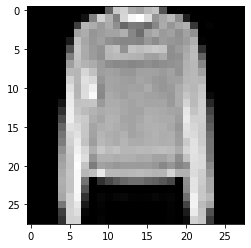

In [ ]:
import matplotlib.pyplot as plt
images, labels=next(iter(train_loader))
print(images.shape,labels.shape)
plt.imshow(images[0][0],cmap="gray")

## 模型构建
PyTorch中神经网络构造一般是基于 Module 类的模型来完成的，它让模型构造更加灵活。  

Module 类是 nn 模块里提供的一个模型构造类，是所有神经⽹网络模块的基类，我们可以继承它来定义我们想要的模型。重载了 Module 类的\_\_init__函数和\_\_forward__ 函数

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net,self).__init__()
    self.conv=nn.Sequential(
        nn.Conv2d(1,32,5),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2),
        nn.Dropout(0.3),
        nn.Conv2d(32,64,5),
        nn.ReLU(),
        nn.MaxPool2d(2,stride=2),
        nn.Dropout(0.3)

    )
    self.fc=nn.Sequential(
        nn.Linear(64*4*4,512),
        nn.ReLU(),
        nn.Linear(512,10)
    )
  def forward(self,x):
    x=self.conv(x)
    x=x.view(-1,64*4*4)
    x=self.fc(x)
    return x
model=Net()
model=model.cuda()
#model=nn.DataParallel(model).cuda()#多卡训练时的写法

一个模型的可学习参数可以通过net.parameters()返回

In [ ]:
params = list(model.parameters())
print(len(params))
print(params[0].size())  # conv1的权重

8
torch.Size([32, 1, 5, 5])


## 损失函数

In [ ]:
criterion=nn.CrossEntropyLoss()          # ?nn.Conv2d  #查找疑问函数

## 优化器

- load_state_dict() ：加载状态参数字典，可以用来进行模型的断点续训练，继续上次的参数进行训练
- state_dict()：获取优化器当前状态信息字典

In [ ]:
optimizer=optim.Adam(model.parameters(),lr=0.001)

## 模型训练与预测

In [ ]:
def train(epoch):
  model.train()
  train_loss=0
  #for i,(data,label) in enumerate(train_loader):          #每一个batch都需要做一些操作
  for data,label in train_loader:
    data,label=data.cuda(),label.cuda()
    optimizer.zero_grad()
    output=model(data)
    loss=criterion(output,label)
    loss.backward()
    optimizer.step()
    train_loss+=loss.item()*data.size(0)
  train_loss=train_loss/len(train_loader.dataset)
  print('Epoch:{} \t Training Loss:{:.6f}'.format(epoch,train_loss))


In [ ]:
def val(epoch):
  model.eval()
  val_loss=0
  gt_labels=[]
  pred_labels=[]
  with torch.no_grad():
    for data,label in test_loader:
      data,label=data.cuda(),label.cuda()
      output=model(data)
      preds=torch.argmax(output,1)
      gt_labels.append(label.cpu().data.numpy())
      pred_labels.append(preds.cpu().data.numpy())
      loss=criterion(output,label)
      val_loss+=loss.item()*data.size(0)
  val_loss=val_loss/len(test_loader.dataset)
  gt_labels,pred_labels=np.concatenate(gt_labels),np.concatenate(pred_labels)
  acc=np.sum(gt_labels==pred_labels)/len(pred_labels)
  print('Epoch:{}\tValidation Loss:{:.6f},Accuracy:{:6f}'.format(epoch,val_loss,acc))

In [ ]:
for epoch in range(1,epochs+1):
  train(epoch)
  val(epoch)

Epoch:1 	 Training Loss:0.232848
Epoch:1	Validation Loss:0.218499,Accuracy:0.916100
Epoch:2 	 Training Loss:0.223912
Epoch:2	Validation Loss:0.212212,Accuracy:0.919200


KeyboardInterrupt: ignored

In [ ]:
gpu_info=!nvidia-smi -i 0
gpu_info='\n'.join(gpu_info)
print(gpu_info)

Tue Aug 30 17:01:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   77C    P0    35W /  70W |   1356MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 补充 优化器实际操作


In [ ]:
import os
import torch

# 设置权重，服从正态分布  --> 2 x 2
weight = torch.randn((2, 2), requires_grad=True)
# 设置梯度为全1矩阵  --> 2 x 2
weight.grad = torch.ones((2, 2))
# 输出现有的weight和data
print("The data of weight before step:\n{}".format(weight.data))
print("The grad of weight before step:\n{}".format(weight.grad))
# 实例化优化器
optimizer = torch.optim.SGD([weight], lr=0.1, momentum=0.9)
# 进行一步操作
optimizer.step()
# 查看进行一步后的值，梯度
print("The data of weight after step:\n{}".format(weight.data))
print("The grad of weight after step:\n{}".format(weight.grad))
# 权重清零
optimizer.zero_grad()
# 检验权重是否为0
print("The grad of weight after optimizer.zero_grad():\n{}".format(weight.grad))
# 输出参数
print("optimizer.params_group is \n{}".format(optimizer.param_groups))
# 查看参数位置，optimizer和weight的位置一样，我觉得这里可以参考Python是基于值管理
print("weight in optimizer:{}\nweight in weight:{}\n".format(id(optimizer.param_groups[0]['params'][0]), id(weight)))
# 添加参数：weight2
weight2 = torch.randn((3, 3), requires_grad=True)
optimizer.add_param_group({"params": weight2, 'lr': 0.0001, 'nesterov': True})
# 查看现有的参数
print("optimizer.param_groups is\n{}".format(optimizer.param_groups))
# 查看当前状态信息
opt_state_dict = optimizer.state_dict()
print("state_dict before step:\n", opt_state_dict)
# 进行5次step操作
for _ in range(50):
    optimizer.step()
# 输出现有状态信息
print("state_dict after step:\n", optimizer.state_dict())
# 保存参数信息
torch.save(optimizer.state_dict(),os.path.join(r"/content/sample_data", "optimizer_state_dict.pkl"))
print("----------done-----------")
# 加载参数信息
state_dict = torch.load(r"/content/sample_data/optimizer_state_dict.pkl") # 需要修改为你自己的路径
optimizer.load_state_dict(state_dict)
print("load state_dict successfully\n{}".format(state_dict))
# 输出最后属性信息
print("\n{}".format(optimizer.defaults))
print("\n{}".format(optimizer.state))
print("\n{}".format(optimizer.param_groups))

The data of weight before step:
tensor([[ 0.5669, -1.4336],
        [-0.0478,  0.0569]])
The grad of weight before step:
tensor([[1., 1.],
        [1., 1.]])
The data of weight after step:
tensor([[ 0.4669, -1.5336],
        [-0.1478, -0.0431]])
The grad of weight after step:
tensor([[1., 1.],
        [1., 1.]])
The grad of weight after optimizer.zero_grad():
tensor([[0., 0.],
        [0., 0.]])
optimizer.params_group is 
[{'params': [tensor([[ 0.4669, -1.5336],
        [-0.1478, -0.0431]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None}]
weight in optimizer:140229849734320
weight in weight:140229849734320

optimizer.param_groups is
[{'params': [tensor([[ 0.4669, -1.5336],
        [-0.1478, -0.0431]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None}, {'params': [tensor([[-0.6185, -0.4379, -0.1994],
       

输出结果

进行更新前的数据，梯度

The data of weight before step:
tensor([[-0.3077, -0.1808],
        [-0.7462, -1.5556]])
The grad of weight before step:
tensor([[1., 1.],
        [1., 1.]])

进行更新后的数据，梯度

The data of weight after step:
tensor([[-0.4077, -0.2808],
        [-0.8462, -1.6556]])
The grad of weight after step:
tensor([[1., 1.],
        [1., 1.]])

进行梯度清零的梯度

The grad of weight after optimizer.zero_grad():
tensor([[0., 0.],
        [0., 0.]])

输出信息

optimizer.params_group is 
[{'params': [tensor([[-0.4077, -0.2808],
        [-0.8462, -1.6556]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}]


证明了优化器的和weight的储存是在一个地方，Python基于值管理
weight in optimizer:1841923407424
weight in weight:1841923407424
    
输出参数

optimizer.param_groups is
[{'params': [tensor([[-0.4077, -0.2808],
        [-0.8462, -1.6556]], requires_grad=True)], 'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}, {'params': [tensor([[ 0.4539, -2.1901, -0.6662],
        [ 0.6630, -1.5178, -0.8708],
        [-2.0222,  1.4573,  0.8657]], requires_grad=True)], 'lr': 0.0001, 'nesterov': True, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0}]

进行更新前的参数查看，用state_dict

state_dict before step:
 {'state': {0: {'momentum_buffer': tensor([[1., 1.],
        [1., 1.]])}}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0]}, {'lr': 0.0001, 'nesterov': True, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'params': [1]}]}

进行更新后的参数查看，用state_dict

state_dict after step:
 {'state': {0: {'momentum_buffer': tensor([[0.0052, 0.0052],
        [0.0052, 0.0052]])}}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0]}, {'lr': 0.0001, 'nesterov': True, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'params': [1]}]}

存储信息完毕

----------done-----------

加载参数信息成功

load state_dict successfully

加载参数信息

{'state': {0: {'momentum_buffer': tensor([[0.0052, 0.0052],
        [0.0052, 0.0052]])}}, 'param_groups': [{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [0]}, {'lr': 0.0001, 'nesterov': True, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'params': [1]}]}

defaults的属性输出

{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False}

state属性输出

defaultdict(<class 'dict'>, {tensor([[-1.3031, -1.1761],
        [-1.7415, -2.5510]], requires_grad=True): {'momentum_buffer': tensor([[0.0052, 0.0052],
        [0.0052, 0.0052]])}})

param_groups属性输出

[{'lr': 0.1, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'params': [tensor([[-1.3031, -1.1761],
        [-1.7415, -2.5510]], requires_grad=True)]}, {'lr': 0.0001, 'nesterov': True, 'momentum': 0.9, 'dampening': 0, 'weight_decay': 0, 'params': [tensor([[ 0.4539, -2.1901, -0.6662],
        [ 0.6630, -1.5178, -0.8708],
        [-2.0222,  1.4573,  0.8657]], requires_grad=True)]}]
